In [67]:
# Se importan las librerías a utilizar en todo el proyecto
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression
from termcolor import colored
from joblib import dump # Permite guardar el estandarizador 

# Se requiere la instalación en el equipo del la librería "imblearn". (pip install imbalanced-learn)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [55]:
# Se carga el Dataframe preparado en la etapa de Análisis con información del estudiante

students = pd.read_csv('res/students_balanced.csv', sep=';')
del students['Unnamed: 0']

students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23058 entries, 0 to 23057
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sum_click          23058 non-null  float64
 1   gender             23058 non-null  float64
 2   region             23058 non-null  float64
 3   highest_education  23058 non-null  float64
 4   studied_credits    23058 non-null  float64
 5   code_module        23058 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.1 MB


## Comparación de algoritmos supervisados

In [56]:
#Partición de datos externa

X = students.copy()
y = students['code_module']
del X['code_module']


X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
valores_training, ocur_training = np.unique(y_training, return_counts=True)
print('Training: ', 'clases:', valores_training, ' ocurrencias: ', ocur_training)
valores_test, ocur_test = np.unique(y_test, return_counts=True)
print('Test: ', 'clases:', valores_test, ' ocurrencias: ', ocur_test)
display(X_training.head(5))

Training:  clases: [1 2 3 4 5 6 7]  ocurrencias:  [2661 2598 2651 2655 2655 2606 2620]
Test:  clases: [1 2 3 4 5 6 7]  ocurrencias:  [633 696 643 639 639 688 674]


,sum_click,gender,region,highest_education,studied_credits
2935,-1.023614,0.928989,1.113127,0.236378,1.549062
7719,1.901206,0.928989,1.621804,0.236378,-0.342115
5405,-1.007619,-1.076439,-0.412902,-1.162380,-0.342115
13868,0.379386,0.928989,1.113127,-1.162380,-1.287704
3948,0.436511,-1.076439,1.367466,-1.162380,-0.342115


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold
from sklearn import preprocessing, svm
import sklearn.metrics as metrics
from evaluacion_funciones import *

# Entrenar cada algoritmo y comparar los resultados (a nivel cuantitativo y cualitativo) sobre el conjunto de test
parameters={'SVM':{'C':(0.1,1,5,10), 'gamma':['auto'], 'kernel':['rbf']},
            'LOGR':{'solver':('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'),
                   'penalty':('l1', 'l2', 'elasticnet', None)},
            'DT':{'criterion':['gini']}}

algs={'SVM':svm.SVC(random_state=42, decision_function_shape='ovr'),
      'LOGR':LogisticRegression(random_state=42, multi_class='ovr'),
      'DT': tree.DecisionTreeClassifier(random_state=42)}

model={}
for name,_ in algs.items():
    print('Algoritmo: ' + name)
    model_cv= GridSearchCV(algs[name], parameters[name], cv=5, return_train_score=True)
    model[name]=model_cv.fit(X_training,y_training)
    cv_res=model[name].cv_results_
    
    print('Best parameters: ', model[name].best_params_)
    best_iter=model[name].best_index_
    print('Accuracy score: %0.4f +/- %0.4f' % (cv_res['mean_test_score'][best_iter], cv_res['std_test_score'][best_iter]))
    print('-----------')

Algoritmo: SVM
Best parameters:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Accuracy score: 0.4809 +/- 0.0105
-----------
Algoritmo: LOGR


/Users/dvelasquez/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
55 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dvelasquez/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dvelasquez/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/dvelasquez/Library/Python/3.9/lib/python/site-packages/sklearn/linea

Best parameters:  {'penalty': 'l2', 'solver': 'newton-cholesky'}
Accuracy score: 0.4322 +/- 0.0045
-----------
Algoritmo: DT
Best parameters:  {'criterion': 'gini'}
Accuracy score: 0.6945 +/- 0.0072
-----------


In [58]:
#Evaluación de los modelos

import pandas as pd

def evaluacion(y_true, y_pred, metricas):
    res = {}
    for nombre, funcion in metricas.items():
        res[nombre] = funcion(y_true, y_pred)
    return res

algoritmos_final = {'SVM': svm.SVC(C=10, gamma='auto', kernel='rbf',random_state=42, probability=True, decision_function_shape='ovr'),
                   'LOGR':LogisticRegression(penalty='l2', solver='newton-cholesky', random_state=42, multi_class='ovr'),
                   'DT': tree.DecisionTreeClassifier(criterion='gini',random_state=42)}

metricas = {
  'ACC':    metrics.accuracy_score}

model_SVM = algoritmos_final['SVM'].fit(X_training, y_training)
model_LOGR = algoritmos_final['LOGR'].fit(X_training, y_training)
model_DT = algoritmos_final['DT'].fit(X_training, y_training)


y_pred_test_SVM = model_SVM.predict(X_test)
y_pred_test_LOGR = model_LOGR.predict(X_test)
y_pred_test_DT = model_DT.predict(X_test)

results_SVM = evaluacion(y_test, y_pred_test_SVM, metricas)

results_LOGR = evaluacion(y_test, y_pred_test_LOGR, metricas)

results_DT = evaluacion(y_test, y_pred_test_DT, metricas)

results_total=pd.DataFrame.from_dict(results_SVM, orient='index', columns=['SVM'])
results_total=pd.DataFrame.from_dict(results_LOGR, orient='index', columns=['LOGR'])
results_total=pd.DataFrame.from_dict(results_DT, orient='index', columns=['DT'])
results_total['SVM']=results_SVM
results_total['LOGR']=results_LOGR
results_total['DT']=results_DT
print(results_total)

           DT       SVM      LOGR
ACC  0.730052  0.489809  0.433868


In [59]:
#Visualización de resultados

print("Matriz de confusión de SVM:")
print(metrics.confusion_matrix(y_test, y_pred_test_SVM))
print("Tabla de métricas SVM:")
print("SVM", metrics.classification_report(y_test, y_pred_test_SVM, digits=3))
print("Matriz de confusión de LOGR:")
print(metrics.confusion_matrix(y_test, y_pred_test_LOGR))
print("Tabla de métricas LOGR:")
print("LOGR", metrics.classification_report(y_test, y_pred_test_LOGR, digits=3))
print("Matriz de confusión de DT:")
print(metrics.confusion_matrix(y_test, y_pred_test_DT))
print("Tabla de métricas DT:")
print("DT", metrics.classification_report(y_test, y_pred_test_DT, digits=3))


Matriz de confusión de SVM:
[[296 104   7  36  94  96   0]
 [100 534   3  28  16  15   0]
 [ 80  59 105  36 139 180  44]
 [134  94  17  79 122 193   0]
 [ 90  40  37  20 254 160  38]
 [ 81  35  45  59  83 385   0]
 [  3  33   1   2  29   0 606]]
Tabla de métricas SVM:
SVM               precision    recall  f1-score   support

           1      0.378     0.468     0.418       633
           2      0.594     0.767     0.670       696
           3      0.488     0.163     0.245       643
           4      0.304     0.124     0.176       639
           5      0.345     0.397     0.369       639
           6      0.374     0.560     0.448       688
           7      0.881     0.899     0.890       674

    accuracy                          0.490      4612
   macro avg      0.480     0.483     0.459      4612
weighted avg      0.484     0.490     0.465      4612

Matriz de confusión de LOGR:
[[ 51 166  67  45 225  79   0]
 [ 20 586   2  28  47  13   0]
 [ 26  83 102  27 216 133  56]
 [ 31 14

In [32]:
y_pred_test_DT_prob = model_DT.predict_proba(X_test)
#y_test_bin_1 = preprocessing.label_binarize(y_pred_test_SVM_prob, classes=[0,1,2,3,4,5,6,7])
display(y_pred_test_DT_prob[1])
display(y_pred_test_DT_prob)
print(type(y_pred_test_DT_prob))
#display(y_test_bin_1[0])

array([0., 0., 1., 0., 0., 0., 0.])

array([[0. , 1. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 1. ],
       [0. , 1. , 0. , ..., 0. , 0. , 0. ]])

<class 'numpy.ndarray'>


In [69]:
start_time = time.time()  # También puedes usar time.perf_counter() para mayor precisión
y_pred = model_DT.predict(X_test)
end_time = time.time()  # También puedes usar time.perf_counter() para mayor precisión

# Calcular el tiempo de predicción
prediction_time = end_time - start_time

print(f"Tiempo de predicción: {prediction_time:.6f} segundos")

Tiempo de predicción: 0.011359 segundos


In [39]:
# Guarda el array en un archivo CSV para comparar resultados 
y_pred_DT = model_DT.predict_proba(X_training)
np.savetxt('res/results_DT.csv', y_pred_DT, delimiter=';')

In [60]:

predicciones = model_DT.predict_proba(X_test)
#print(np.argmax(predicciones[0]))
results=np.array([])
x=0
ok=0
ok2=0
ok3=0
ok4=0
ok5=0
ok6=0
ok7=0
nok=0
nok2=0
nok3=0
nok4=0
nok5=0
nok6=0
nok7=0

for i in predicciones:
    results = np.append(results, np.argmax(i)+1)
    if results[x] == y_test.iloc[x]:
        ok=ok+1
    else:
        nok=nok+1
        i[np.argmax(i)] = 0
        seg = np.argmax(i)+1
        if seg == y_test.iloc[x]:
            ok2=ok2+1
        else:
            nok2 = nok2 + 1
            i[np.argmax(i)] = 0
            ter = np.argmax(i)+1
            if ter == y_test.iloc[x]:
                ok3=ok3+1
            else:
                nok3 = nok3 + 1
                i[np.argmax(i)] = 0
                cua = np.argmax(i)+1
                if cua == y_test.iloc[x]:
                    ok4=ok4+1
                else:
                    nok4 = nok4 + 1
                    i[np.argmax(i)] = 0
                    qui = np.argmax(i)+1
                    if qui == y_test.iloc[x]:
                        ok5=ok5+1
                    else:
                        nok5 = nok5 + 1
                        i[np.argmax(i)] = 0
                        sext = np.argmax(i)+1
                        if sext == y_test.iloc[x]:
                            ok6=ok6+1
                        else:
                            nok6 = nok6 + 1
                            i[np.argmax(i)] = 0
                            sie = np.argmax(i)+1
                            if sie == y_test.iloc[x]:
                                ok7=ok7+1
                            else:
                                nok7 = nok7 + 1
    x=x+1


print("OK: ", ok)
print("NOK: ", nok)
print("OK 2: ", ok2)
print("NOK 2: ", nok2)
print("OK 3: ", ok3)
print("NOK 3: ", nok3)
print("OK 4: ", ok4)
print("NOK 4: ", nok4)
print("OK 5: ", ok5)
print("NOK 5: ", nok5)
print("OK 6: ", ok6)
print("NOK 6: ", nok6)
print("OK 7: ", ok7)
print("NOK 7: ", nok7)
print("Probabilidad de 1 opción: ", (ok)/(4612)*100)
print("Probabilidad de 2 opciones: ", (ok+ok2)/(4612)*100)
print("Probabilidad de 3 opciones: ", (ok+ok2+ok3)/(4612)*100)
print("Probabilidad de 4 opciones: ", (ok+ok2+ok3+ok4)/(4612)*100)
print("Probabilidad de 5 opciones: ", (ok+ok2+ok3+ok4+ok5)/(4612)*100)
print("Probabilidad de 6 opciones: ", (ok+ok2+ok3+ok4+ok5+ok6)/(4612)*100)
print("Probabilidad de 7 opciones: ", (ok+ok2+ok3+ok4+ok5+ok6+ok7)/(4612)*100)

OK:  3367
NOK:  1245
OK 2:  169
NOK 2:  1076
OK 3:  3
NOK 3:  1073
OK 4:  0
NOK 4:  1073
OK 5:  0
NOK 5:  1073
OK 6:  0
NOK 6:  1073
OK 7:  0
NOK 7:  1073
Probabilidad de 1 opción:  73.00520381613183
Probabilidad de 2 opciones:  76.6695576756288
Probabilidad de 3 opciones:  76.73460537727667
Probabilidad de 4 opciones:  76.73460537727667
Probabilidad de 5 opciones:  76.73460537727667
Probabilidad de 6 opciones:  76.73460537727667
Probabilidad de 7 opciones:  76.73460537727667


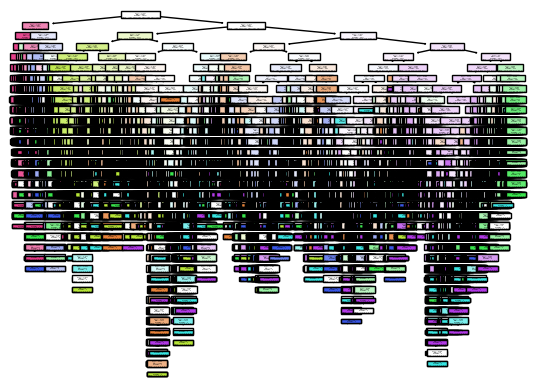

In [45]:
# 5.3) Ploteamos el árbol con todos los datos para visualización árbol.

model_DT = algoritmos_final['DT'].fit(X_training, y_training)
plt.figure()
tree.plot_tree(model_DT,filled=True)  
plt.savefig('tree_' + "DT" + '.pdf',format='pdf',bbox_inches = "tight")